In [1]:
import warnings
warnings.filterwarnings("ignore")


# Práctica: Modelo climático 1D de balance energético (albedo suave)

En este cuaderno se utiliza un modelo climático idealizado de balance energético unidimensional (1D), implementado con la librería **climlab**, para estudiar de forma conceptual cómo responde el sistema climático a un forzamiento radiativo externo.

El objetivo de la práctica **no es aprender programación en Python**, ni entender el funcionamiento interno de la librería, sino **interpretar los resultados físicos del modelo** y relacionarlos con los conceptos vistos en la asignatura.

A lo largo del cuaderno se ejecutará código que puede considerarse una *caja negra* (no necesitamos entender el detalle del código).  
No es necesario modificarlo ni comprenderlo en detalle. En cada sección se indicará claramente **qué se está haciendo** y **qué debe observarse en los resultados**.







## Preparación del entorno y carga de librerías

En esta sección se cargan las librerías necesarias y se configuran algunos parámetros generales del modelo.  

In [2]:
#Librerias y versión del paquete climlab
import numpy as np
import matplotlib.pyplot as plt
import climlab

print("climlab version:", climlab.__version__)



climlab version: 0.9.1


### Tiempo de ajuste (spin-up)

Antes de analizar los resultados del modelo, es necesario dejarlo evolucionar durante un cierto tiempo para que pierda la memoria de las condiciones iniciales y alcance un estado estable.

Este período se denomina *spin-up*.

En esta práctica, el número de años de spin-up se controla mediante el parámetro **NYEARS_SPINUP**, que el estudiante puede modificar.


In [3]:
# Parámetros del modelo sencillo

# Horizonte temporal de integración (años)
NYEARS_SPINUP = 20



In [4]:
# Forzamiento radiativo (W m^-2)
# Se implementa como A -> A - F en la parametrización OLR = A + B*T
F = 0.0

## El modelo climático utilizado en la práctica

En esta práctica no se construye un modelo climático desde cero. En su lugar, se utiliza un **modelo climático idealizado de balance energético unidimensional (1D)** que ya está implementado en la librería *climlab*.

Esta librería proporciona implementaciones estándar de modelos climáticos simplificados, ampliamente utilizados con fines didácticos y de investigación. El trabajo de formulación matemática del modelo (ecuaciones, parametrizaciones y supuestos físicos) ya ha sido realizado previamente y no forma parte de esta práctica.

La línea de código que aparece a continuación crea una **instancia** de un modelo EBM 1D estacional ya definido, que representa la temperatura superficial media como función de la latitud y del momento del año.

El modelo incluye, de forma simplificada:
- radiación solar entrante dependiente de la latitud y de la estación;
- emisión infrarroja hacia el espacio parametrizada de forma lineal;
- un término difusivo que aproxima el transporte meridional de energía desde regiones más cálidas hacia regiones más frías.

En esta primera parte de la práctica, el albedo es fijo y no depende de la temperatura, de modo que el sistema presenta un comportamiento suave y reversible frente a perturbaciones externas.



In [5]:
# Construcción del modelo climático EBM 1D estacional (albedo suave)
m = climlab.EBM_seasonal()


## Ajuste inicial del modelo (spin-up)

Al iniciar el modelo desde una condición inicial arbitraria, la temperatura del sistema no representa todavía un estado climático realista. Es necesario integrar el modelo durante un cierto tiempo para que la solución pierda la dependencia de las condiciones iniciales y alcance un régimen estacionario.

Este periodo de ajuste se denomina **spin-up**.  
Durante el spin-up, el modelo evoluciona libremente hasta que las variables climáticas muestran un comportamiento estable y repetible (por ejemplo, un ciclo estacional que se repite año tras año).

Solo una vez completado el spin-up se analizan e interpretan los resultados del modelo.


In [6]:
# Ajuste inicial del modelo (spin-up)
# El modelo se integra durante varios años para eliminar la dependencia
# de la condición inicial y alcanzar un régimen climático estable.

for _ in range(NYEARS_SPINUP):
    m.integrate_years(1)


Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.000000000000006 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.000000000000019 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.000000000000032 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 5.000000000000044 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 6.0000000000000355 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 6.999999999999992 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 7.999999999999949 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 8.999999999999906 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 9.999999999999863 years

### Extracción y visualización de los resultados del modelo

Una vez completado el período de ajuste inicial (*spin-up*), el modelo se encuentra en un régimen climático estable, con un ciclo estacional que se repite año tras año.

En las siguientes celdas se extraen y visualizan los resultados del modelo correspondientes a **un año completo** de simulación, con el objetivo de analizar:

- cómo varía la temperatura media con la latitud;
- cómo es el ciclo estacional de la temperatura en distintas regiones del planeta.

El código que aparece a continuación se encarga únicamente de **almacenar los valores de temperatura que calcula el modelo y representarlos gráficamente**. No es necesario modificarlo ni entender su funcionamiento interno en detalle.


**Almacenamiento de la evolución temporal de la temperatura**

En esta celda se hace lo siguiente:

- se obtiene la rejilla de latitudes del modelo;
- se determina cuántos pasos de integración corresponden aproximadamente a un año;
- se almacena la temperatura superficial calculada por el modelo en cada latitud, a lo largo de un ciclo anual completo.

El resultado es una matriz que contiene la evolución temporal de la temperatura superficial para todas las latitudes durante un año representativo, una vez alcanzado el equilibrio climático.


In [7]:
# Coordenada de latitud
lat = m.state['Ts'].domain.axes['lat'].points

# Paso temporal del modelo (en días)
dt_days = m.timestep / 86400.0
nsteps_year = int(round(365.0 / dt_days))

# Almacenamos la evolución de Ts durante un año completo
Ts_year = np.zeros((len(lat), nsteps_year))

for k in range(nsteps_year):
    m.step_forward()
    Ts_year[:, k] = np.array(m.state['Ts']).ravel()

# Temperatura media anual en cada latitud
Ts_ann = Ts_year.mean(axis=1)

# Eje temporal (días del año)
time_days = np.arange(nsteps_year) * dt_days


**Perfil latitudinal de la temperatura media anual**

A partir de los datos almacenados en la celda anterior, aquí se calcula:

- la **temperatura media anual** en cada latitud, promediando sobre el ciclo estacional.

La figura resultante muestra el perfil latitudinal de la temperatura superficial media anual del planeta según el modelo:

- temperaturas más altas en bajas latitudes;
- temperaturas más bajas hacia los polos;
- un gradiente latitudinal suave, mantenido por el transporte meridional de energía.

Este perfil representa el estado climático medio del sistema en ausencia de forzamientos externos adicionales.


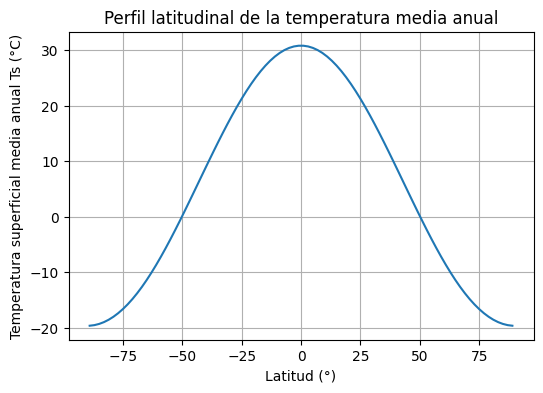

In [8]:
plt.figure(figsize=(6,4))
plt.plot(lat, Ts_ann)
plt.xlabel("Latitud (°)")
plt.ylabel("Temperatura superficial media anual Ts (°C)")
plt.title("Perfil latitudinal de la temperatura media anual")
plt.grid(True)
plt.show()


**Ciclo estacional de la temperatura en distintas latitudes**

En esta celda se analiza cómo varía la temperatura a lo largo del año en varias latitudes representativas:

- una latitud tropical (cerca del ecuador),
- una latitud media,
- una latitud alta.

La figura muestra el **ciclo estacional de la temperatura superficial** en cada una de estas regiones.

Se observa que:

- en el ecuador, la variación estacional es pequeña;
- en latitudes medias, el ciclo estacional es más marcado;
- en altas latitudes, la amplitud del ciclo estacional es máxima.

Este comportamiento refleja la dependencia latitudinal de la radiación solar entrante y es una de las características fundamentales del sistema climático.


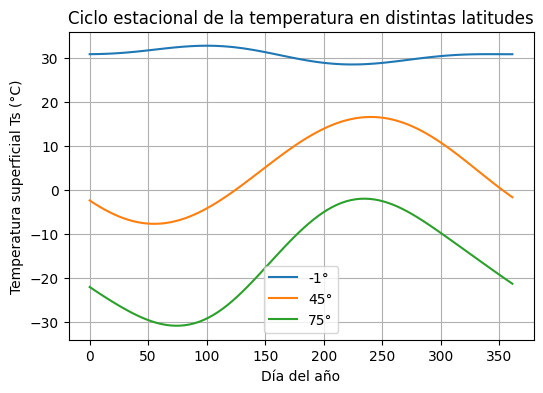

In [9]:
# Latitudes de referencia para el ciclo estacional
target_lats = [0, 45, 75]
idx = [int(np.argmin(np.abs(lat - x))) for x in target_lats]

plt.figure(figsize=(6,4))
for x, i in zip(target_lats, idx):
    plt.plot(time_days, Ts_year[i, :], label=f"{lat[i]:.0f}°")

plt.xlabel("Día del año")
plt.ylabel("Temperatura superficial Ts (°C)")
plt.title("Ciclo estacional de la temperatura en distintas latitudes")
plt.legend()
plt.grid(True)
plt.show()


### Experimento: condiciones iniciales y ajuste (spin-up)

Para visualizar qué significa una *condición inicial* y cómo el modelo alcanza un régimen estable, fijaremos una temperatura inicial uniforme (la misma en todas las latitudes) y dejaremos evolucionar el sistema durante varios años.

Guardaremos un resumen anual del estado del modelo para observar:
- cómo cambia la temperatura media global con el tiempo;
- cómo se forma progresivamente el perfil latitudinal.


In [23]:
# Condición inicial uniforme (el estudiante puede cambiar T0_C si quiere)
T0_C = 15.0  # °C

# Convertimos a Kelvin (climlab suele trabajar en K)
T0_K = T0_C + 273.15

# Fijamos Ts uniforme en todas las latitudes
Ts_field = m.state['Ts']
Ts_field[:] = T0_K


In [24]:
# Número de años que queremos observar explícitamente antes de considerar el equilibrio
NYEARS_TRACK = 10

lat = m.state['Ts'].domain.axes['lat'].points

# Pesos de área ~ cos(lat) para un modelo zonal
weights = np.cos(np.deg2rad(lat))
weights = weights / weights.sum()

Tmean_by_year = []
Ts_profiles = []

for y in range(NYEARS_TRACK + 1):
    # Guardamos el estado actual (año y)
    Ts_now = np.array(m.state['Ts']).ravel()

    # Conversión robusta: si parece Kelvin, pasamos a °C; si no, dejamos tal cual
    if Ts_now.mean() > 150:   # umbral seguro: en °C no deberías ver valores > 150
        Ts_now_C = Ts_now - 273.15
    else:
        Ts_now_C = Ts_now
    Ts_profiles.append(Ts_now_C.copy())
    Tmean_by_year.append(float(np.sum(weights * Ts_now_C)))

    
    # Avanzamos 1 año (excepto tras guardar el último)
    if y < NYEARS_TRACK:
        m.integrate_years(1)


Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 47.000000000003766 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 48.00000000000395 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 49.00000000000413 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 50.00000000000431 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 51.00000000000449 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 52.000000000004675 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 53.00000000000485 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 54.00000000000504 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 55.000000000005215 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 56.00000000000539 year

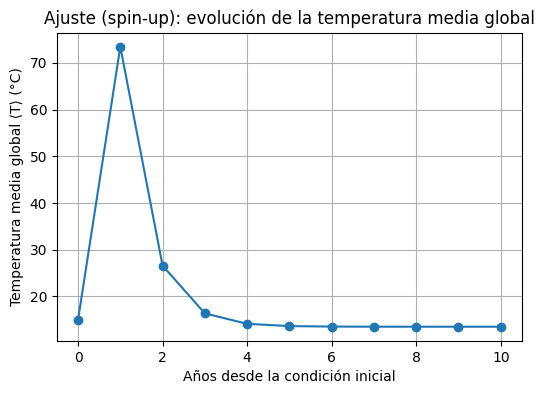

In [25]:
years = np.arange(NYEARS_TRACK + 1)

plt.figure(figsize=(6,4))
plt.plot(years, Tmean_by_year, marker='o')
plt.xlabel("Años desde la condición inicial")
plt.ylabel("Temperatura media global ⟨T⟩ (°C)")
plt.title("Ajuste (spin-up): evolución de la temperatura media global")
plt.grid(True)
plt.show()


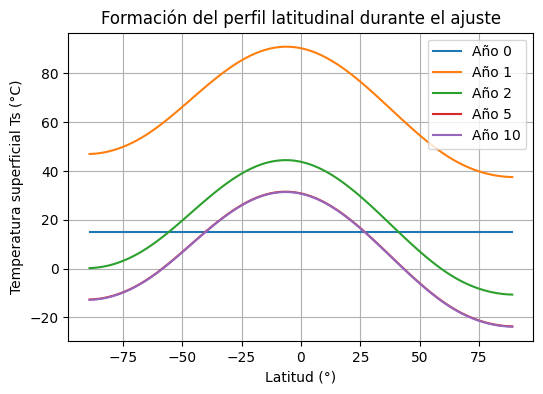

In [27]:
plt.figure(figsize=(6,4))
for y in [0, 1, 2, 5,10]:
    if y <= NYEARS_TRACK:
        plt.plot(lat, Ts_profiles[y], label=f"Año {y}")

plt.xlabel("Latitud (°)")
plt.ylabel("Temperatura superficial Ts (°C)")
plt.title("Formación del perfil latitudinal durante el ajuste")
plt.legend()
plt.grid(True)
plt.show()


## Respuesta del modelo a un forzamiento radiativo externo

En esta sección se estudia cómo responde el modelo climático a un **forzamiento radiativo externo**.

En el contexto de este modelo, un forzamiento radiativo representa una modificación externa del balance energético del sistema climático (por ejemplo, debida a cambios en la concentración de gases de efecto invernadero).

Ya veíamos que el forzamiento se introduce mediante un parámetro F que modifica el término de radiación infrarroja emitida (OLR), de modo que el sistema recibe, en promedio, más energía de la que emite. Tras aplicar el forzamiento, el modelo se integra de nuevo hasta alcanzar un nuevo estado estacionario.


Este parámetro permite simular, de forma muy idealizada, el efecto de cambios externos en el balance energético del sistema climático (por ejemplo, un aumento de gases de efecto invernadero).

Inicialmente habíamos establecido ese valor como nulo pero ahora **se puede modificar el valor de F puede libremente** en esta celda, ejecutando de nuevo el cuaderno para analizar cómo responde el sistema climático.


In [31]:
# Aplicación del forzamiento radiativo
# El forzamiento F se implementa como una reducción del parámetro A
# en la parametrización OLR = A + B*T
F=10.0

In [ ]:
m.subprocess['LW'].A -= F

Tras introducir el forzamiento radiativo, el modelo deja de estar en equilibrio.  
Es necesario integrar de nuevo el sistema durante un cierto tiempo para que alcance un nuevo estado estacionario coherente con el forzamiento aplicado.


In [32]:
# Nuevo periodo de ajuste tras aplicar el forzamiento radiativo

for _ in range(NYEARS_SPINUP):
    m.integrate_years(1)


Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 44.000000000003226 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 45.0000000000034 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 46.00000000000359 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 47.000000000003766 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 48.00000000000395 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 49.00000000000413 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 50.00000000000431 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 51.00000000000449 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 52.000000000004675 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 53.00000000000485 years

In [33]:
# Almacenamos la evolución de Ts durante un año completo tras el forzamiento
Ts_year_F = np.zeros((len(lat), nsteps_year))

for k in range(nsteps_year):
    m.step_forward()
    Ts_year_F[:, k] = np.array(m.state['Ts']).ravel()

# Temperatura media anual tras el forzamiento
Ts_ann_F = Ts_year_F.mean(axis=1)


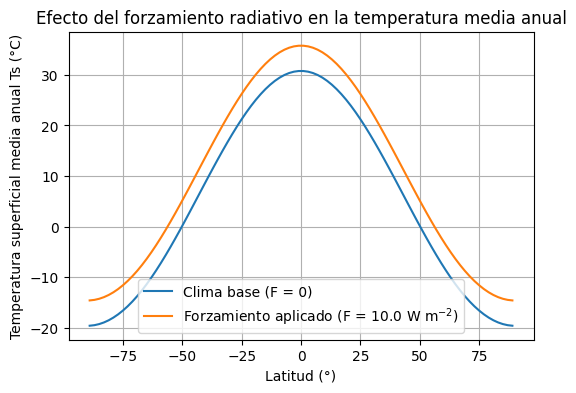

In [34]:
plt.figure(figsize=(6,4))
plt.plot(lat, Ts_ann, label="Clima base (F = 0)")
plt.plot(lat, Ts_ann_F, label=f"Forzamiento aplicado (F = {F} W m$^{{-2}}$)")
plt.xlabel("Latitud (°)")
plt.ylabel("Temperatura superficial media anual Ts (°C)")
plt.title("Efecto del forzamiento radiativo en la temperatura media anual")
plt.legend()
plt.grid(True)
plt.show()


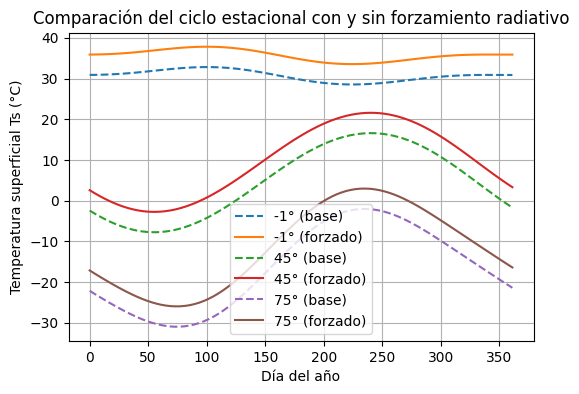

In [35]:
plt.figure(figsize=(6,4))
for x, i in zip(target_lats, idx):
    plt.plot(time_days, Ts_year[i, :], linestyle="--", label=f"{lat[i]:.0f}° (base)")
    plt.plot(time_days, Ts_year_F[i, :], label=f"{lat[i]:.0f}° (forzado)")

plt.xlabel("Día del año")
plt.ylabel("Temperatura superficial Ts (°C)")
plt.title("Comparación del ciclo estacional con y sin forzamiento radiativo")
plt.legend()
plt.grid(True)
plt.show()


Al comparar el clima base con el clima forzado se observa que:

- la temperatura aumenta en todas las latitudes;
- el calentamiento no es uniforme, siendo diferente según la latitud;
- el modelo alcanza un nuevo estado estacionario tras el periodo de ajuste;
- para este modelo con albedo fijo, la respuesta es suave y no depende de la historia previa del sistema.

Este comportamiento cambiará al introducir un feedback adicional en el siguiente cuaderno de la práctica.


## Resumen de resultados

En este cuaderno se ha trabajado con un modelo climático sencillo que presenta una respuesta suave y reversible al forzamiento radiativo externo.

Se ha observado que:
- el modelo alcanza un estado estacionario tras un periodo de spin-up;
- un forzamiento radiativo positivo desplaza la temperatura hacia valores más altos;
- la respuesta del sistema es aproximadamente monótona y no depende de las condiciones iniciales.

En el siguiente cuaderno de la práctica se introducirá un feedback adicional que modificará de forma cualitativa este comportamiento, dando lugar a respuestas no lineales y a la posible dependencia de la historia del sistema.
